# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [54]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import time 

from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder


from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

RND = 12345

Загрузим все необходимые библиотеки и инструменты

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Загрузим датасет

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
display(df.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
display(df.describe(include=['object', 'bool']))

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


In [7]:
print('Duplicates: ', df.duplicated().sum())

Duplicates:  4


Изучим данные

In [8]:
new_columns = df.columns.str.lower()
df.set_axis(new_columns, axis = 'columns', inplace = True)

Приведем названия столбцов к нижнему регистру

In [9]:
df = df.drop(['datecrawled', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen', 'registrationmonth'], axis=1)

Удалим ненужные столбцы

In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354369 non-null  int64 
 1   vehicletype       316879 non-null  object
 2   registrationyear  354369 non-null  int64 
 3   gearbox           334536 non-null  object
 4   power             354369 non-null  int64 
 5   model             334664 non-null  object
 6   kilometer         354369 non-null  int64 
 7   fueltype          321474 non-null  object
 8   brand             354369 non-null  object
 9   repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB
None


<h1>Вывод по данным:</h1>

<ol>354365 строк и 16 столбцов
<li>Присутствуют пропуски</li>
<li>Средняя стоимость авто 2700 евро</li>
<li>Минимальный год регистриции автомобиля 1000, максимальный - 9999. Предлагаю обозначить диапазон в годах, выделенных из процентилей</li>
<li>Макс.значение в мощности автомобиля в лошадинных силах = 20 000. Показатель весьма фантастический. Выберем диапазон из процентилей</li>
<li>Минимальный пробег авто 5000, максимальный - 150000, но при этом много авто имееют максимальный пробег. Возможно просто ограничение ввода данных на сайте</li>
<li>Неправильно выставлены месяцы. Если первый месяц 0, то последний месяц не должен быть 12</li>
<li>8 уникальных типов автомобильного кузова</li>
<li>Чаще встречаются авто с ручной коробкой передач</li>
<li>Чаще встречаются автомобиле на бензине</li>
<li>Самый популярный бренд автомо Volkswagen</li>
<li>Много пропусков в столбце о ремонте авто, но чаще встречаютс автомобили без ремонта</ol>

<h1>Анализ данных и обработка:</h1>

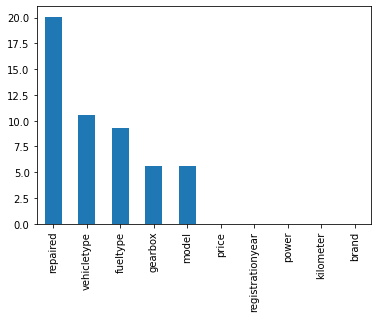

In [11]:
(df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100).plot(kind='bar');

Посмотрим на пропущенные значения:
<ul><li>20% в столбце repaired. Скорее всего владельцы пропустили это значения потому что авто прежде не ремонтировалось. Либо просто скрыли информацию, чтобы автомобиль не казался менее привлекательным к покупке</li>
<li>10% в столбце vehicletype</li>
<li>9% в столбце fueltype</li>
<li>5% в столбце gearbox</li>
<li>5% в столбце model</li></ul>
Остальные столбцы имеют пропуски возможно по причине проблем с выгрузкой данных, так как на эти вопросы может ответить только владельцы автомобилей. Заполним пропуски модами с помощью группировки по другим признакам объектов.

In [12]:
df['repaired'] = df['repaired'].fillna('no')

Заменим пропуски в столбце reparied

In [13]:
def fill_with_mode(column, column1, column2):
    df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [14]:
fill_with_mode('model', 'brand', 'registrationyear')
fill_with_mode('fueltype', 'brand', 'model')
fill_with_mode('vehicletype', 'brand', 'model')
fill_with_mode('gearbox', 'brand', 'model')

In [15]:
filled_columns = ['model', 'gearbox', 'brand', 'vehicletype', 'fueltype']
def count_empty_category(column):
    print(column, ' : ' ,df[column][df[column] == 'Empty'].count())

In [16]:
for column in filled_columns:
    count_empty_category(column)

model  :  3442
gearbox  :  21
brand  :  0
vehicletype  :  25
fueltype  :  14


3442 объекта продажи с неизвестными моделями авто. Предлагаю их переименовать в Other. Остальные показатели малы.

In [17]:
df['model'] = df['model'].replace('Empty', 'other')

In [18]:
def make_plotbar(index, title):
    pivot = pd.DataFrame(df.pivot_table(index=index, aggfunc="size").sort_values(ascending=False)).head(10)
    pivot.columns = ['count']
    plt.figure(figsize=(12,6))
    plt.title(title)
    sns.barplot(x='count', y=pivot.index, data=pivot)

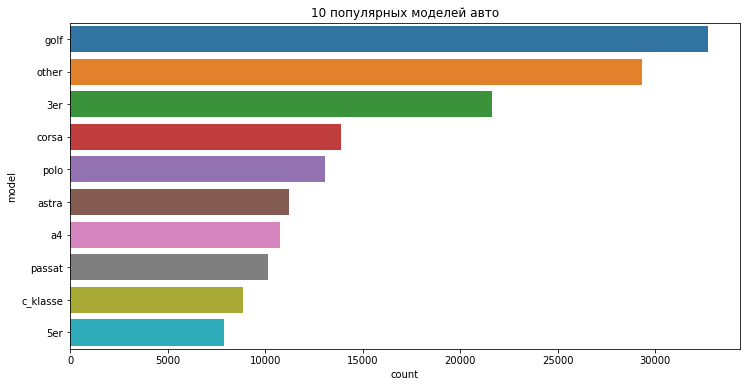

In [19]:
make_plotbar('model', '10 популярных моделей авто')

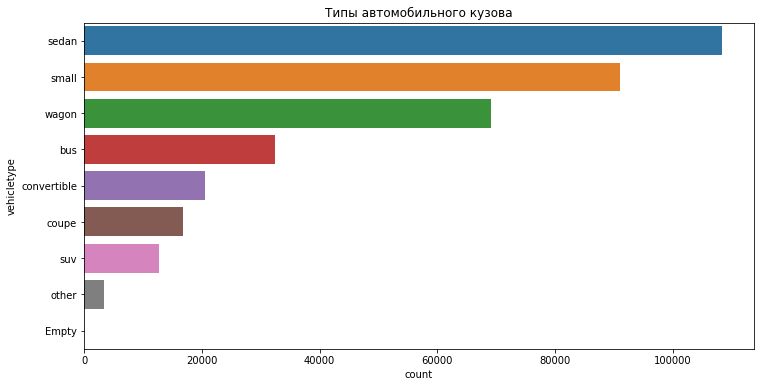

In [20]:
make_plotbar('vehicletype', 'Типы автомобильного кузова')

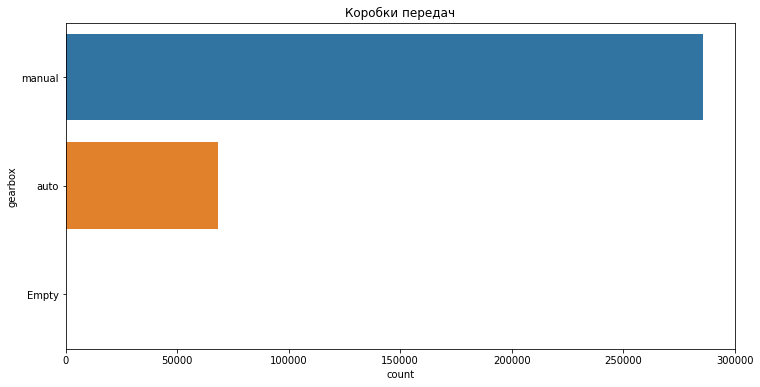

In [21]:
make_plotbar('gearbox', 'Коробки передач')

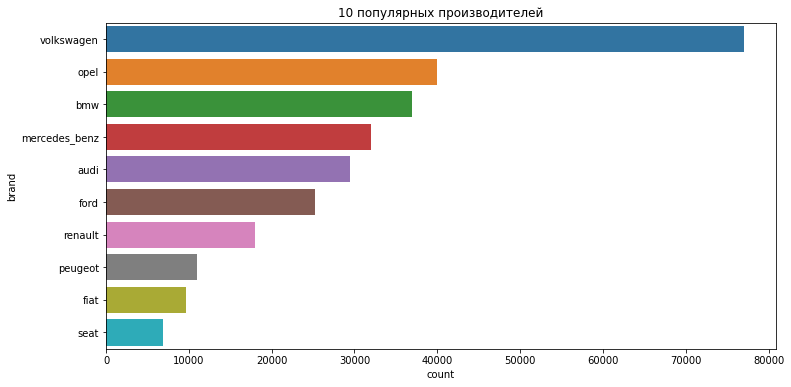

In [22]:
make_plotbar('brand', '10 популярных производителей')

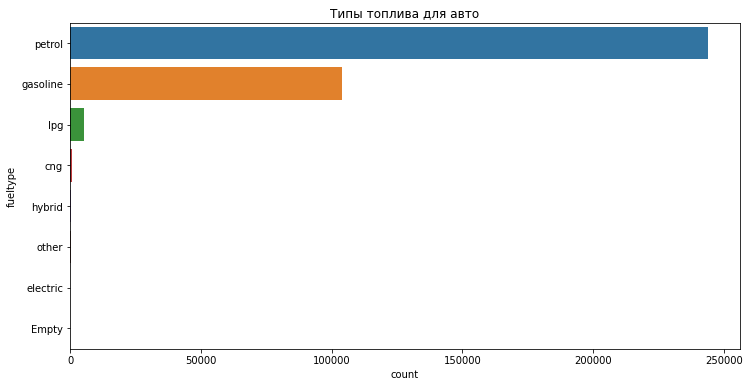

In [23]:
make_plotbar('fueltype', 'Типы топлива для авто')

По итогам изучения категориальных признаков видим, что: 
    <ul><li>Самая популярная модель авто - golf</li>
    <li>Самый популярный тип автомобильного кузова - седан</li>
    <li>Автомобили с ручной коробкой передач превышают по количеству автомобили с автоматической коробкой передач</li>
    <li>Volskwagen - самый продаваемый автомобиль</li>
    <li>Бензин - самое популярное топливо</li></ul>

In [24]:
cars_for_free = df.query('price == 0')
cars_for_free.shape

(10772, 10)

10772 автомобиля отдаются бесплатно. На фоне остального датасета это немного строк. Думаю их можно просто убрать

In [25]:
df = df.query('price != 0')

Убрали

In [26]:
perc = np.arange(0,1,0.05)

In [27]:
df['power'].describe(percentiles = perc)

count    343597.000000
mean        111.000192
std         188.177974
min           0.000000
0%            0.000000
5%            0.000000
10%           0.000000
15%          54.000000
20%          60.000000
25%          69.000000
30%          75.000000
35%          82.000000
40%          90.000000
45%         101.000000
50%         105.000000
55%         110.000000
60%         116.000000
65%         125.000000
70%         136.000000
75%         143.000000
80%         150.000000
85%         170.000000
90%         180.000000
95%         218.000000
max       20000.000000
Name: power, dtype: float64

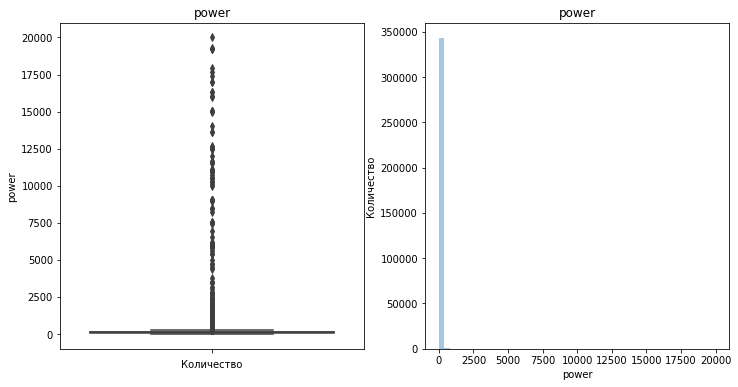

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('power')
sns.boxplot(y = 'power', data=df, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('power')
sns.distplot(df['power'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')
            
plt.show()

Увы, много выбросов.

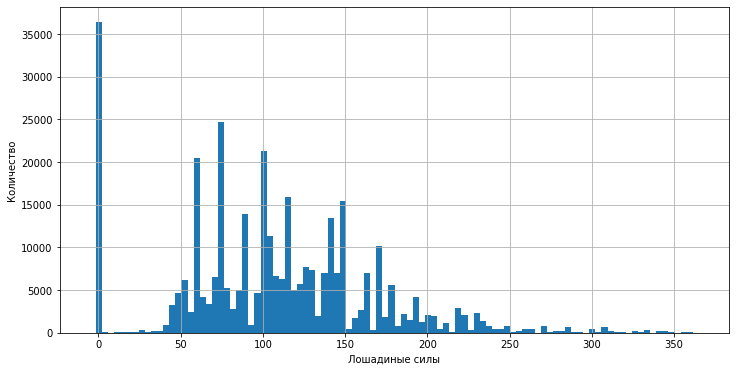

In [29]:
Q1 = df['power'].quantile(0.25)
Q3 = df['power'].quantile(0.75)
IQR = Q3 - Q1
fig, ax = plt.subplots()
df['power'].plot(kind = 'hist', bins = 100, grid = True, range = (Q1 - IQR, Q3 + 3*IQR), figsize = (12, 6))
ax.set_xlabel('Лошадиные силы')
ax.set_ylabel('Количество');

Мы взяли квантили от показателей столбца для графика, и судя по нему в основном встречаются авто с мощностью до 350 лс. Примем 350 лс как максимум диапазона, а нули заменим на медианы относительно групп моделей объектов

In [30]:
df = df.query('power <= 350')

In [31]:
medians  = df.groupby('model')['power'].median().to_dict()
def fill_with_median (row):
    if row['power'] == 0:
        return medians [row['model']]
    return row ['power']
df['power'] = df.apply(lambda row: fill_with_median(row), axis = 1)

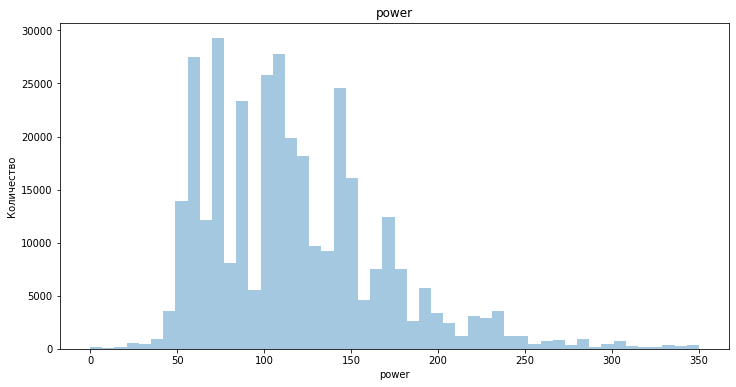

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('power')
sns.distplot(df['power'], kde=False, bins=50, ax = ax)
ax.set_ylabel('Количество')          
plt.show()

Убрали выбросы и нули. Стало лучше.

In [33]:
df['registrationyear'].describe(percentiles=perc)

count    342441.000000
mean       2004.074962
std          77.973936
min        1000.000000
0%         1000.000000
5%         1993.000000
10%        1996.000000
15%        1997.000000
20%        1998.000000
25%        1999.000000
30%        2000.000000
35%        2000.000000
40%        2001.000000
45%        2002.000000
50%        2003.000000
55%        2004.000000
60%        2005.000000
65%        2006.000000
70%        2007.000000
75%        2008.000000
80%        2009.000000
85%        2010.000000
90%        2012.000000
95%        2016.000000
max        9999.000000
Name: registrationyear, dtype: float64

Возьмем область от 5% в столбе года регистрации

In [34]:
df = df.query('registrationyear >= 1992 and registrationyear < 2016')

In [35]:
df = df.drop_duplicates().reset_index(drop=True)

Удалим дубликаты

In [36]:
def make_price_plot(feature, title):
    mean_price = df[[feature, 'price']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(12,6))
    plt.grid(axis = 'both')
    sns.lineplot(x=feature, y='price', data=mean_price)
    plt.xlabel(feature, size=12)
    plt.ylabel('Средняя цена в евро', size=12)
    plt.title(title, size=15, y=1.02)
    plt.show()

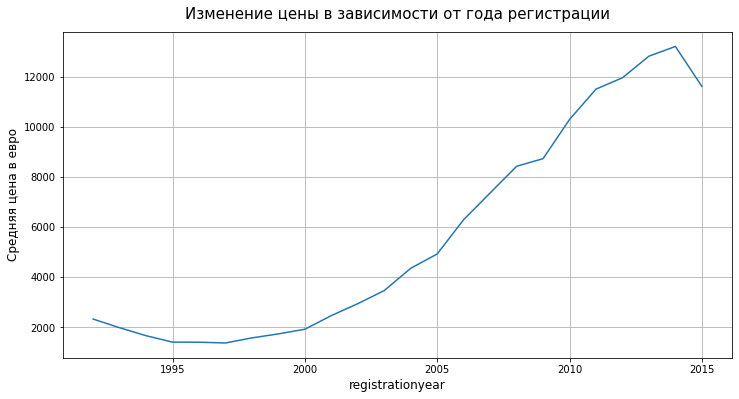

In [37]:
make_price_plot('registrationyear', 'Изменение цены в зависимости от года регистрации')

С чем связано резкое падение цен в 2015 году можно только предпологать. Может быть кризис?

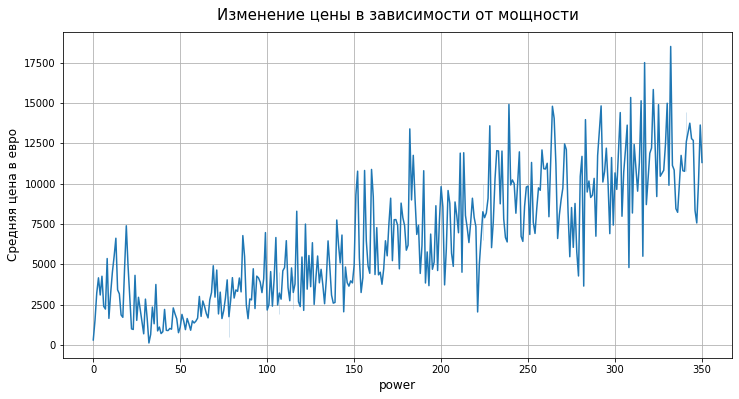

In [38]:
make_price_plot('power', 'Изменение цены в зависимости от мощности')

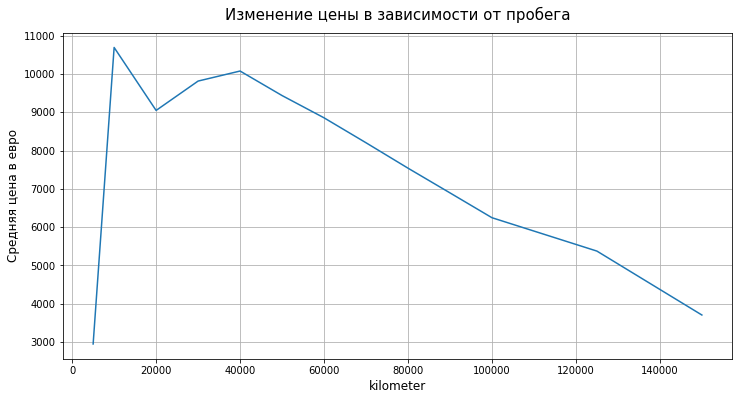

In [39]:
make_price_plot('kilometer', 'Изменение цены в зависимости от пробега')

In [40]:
df.shape

(251317, 10)

После анализа и обработки мы потеряли 1\10 данных. Думаю это не сильно повлияет на дальнейшую работу

## Обучение моделей

In [43]:
features = df.drop('price', axis=1)
target = df['price']

Разделим датасет на признаки и целевой признак

In [45]:
cats_cols = list(features.select_dtypes(include='object').columns)
label_encode = LabelEncoder()
for column in cats_cols:
    label_encode.fit(features[column].astype('str'))
    features[column] = label_encode.transform(features[column].astype('str'))

In [46]:
cats_cols

['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RND)
X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=RND)

Поделили данные на обучающую, тестовую и валидационную выборки

In [48]:
def scale_to_standard(train, test, valid):
    scaler = StandardScaler()
    quanti_columns = ['registrationyear', 'power', 'kilometer']
    scaler.fit(train[quanti_columns])
    train[quanti_columns] = scaler.transform(train[quanti_columns])
    valid[quanti_columns]=scaler.transform(valid[quanti_columns])
    test[quanti_columns] = scaler.transform(test[quanti_columns])

In [49]:
scale_to_standard(X_train, X_test, X_train_valid)

Стандартизировали их

In [50]:
def rmse(test,predict):
    return ((mse(test,predict))**0.5).round(2)

Создадим функцию rmse

<h1>DecisionTreeRegressor</h1>

In [51]:
def DTR (features, target):
    model = DecisionTreeRegressor()
    params = {
        'max_depth' : [5, 7, 10]
                }
    grid_cv = GridSearchCV(estimator=model, 
    param_grid=params, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [55]:
%%time
lr_params = DTR(X_train, y_train)

Best hyperparams:  {'max_depth': 10}
RMSE score on train sample: 1940.90
CPU times: user 3.74 s, sys: 15.4 ms, total: 3.75 s
Wall time: 3.76 s


In [56]:
%%time
model_lr = DecisionTreeRegressor(**lr_params)
model_lr.fit(X_test, y_test)
predict_lr = model_lr.predict(X_train_valid)
print('Test RMSE = {:.2f}'.format(mse(y_train_valid, predict_lr)**0.5))

Test RMSE = 1804.57
CPU times: user 113 ms, sys: 3.24 ms, total: 116 ms
Wall time: 117 ms


Использовав модель DecisionTreeRegressor мы получили показатели:

на обучающей выборке: 1940.90 на валидационной выборке: 1804.57

<h1>LightGBM </h1>

In [ ]:
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10],
        'verbose' : [10],        
        'random_state' : [RND],
        'force_col_wise': [True],
        'num_leaves' : [127]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, categorical_feature=cats_cols)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [ ]:
%%time
lgb_params = lgb_regr(X_train, y_train)

In [ ]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=10, eval_metric='rmse')
predict_lgb = model_lgb.predict(X_train_valid)
print('Test RMSE = {:.2f}'.format(mse(y_train_valid, predict_lgb)**0.5))

Использовав модель LightGBM  мы получили показатели:

на обучающей выборке: 1573.23
на валидационной выборке: 1594.86

<h1>CatBoost</h1>

In [ ]:
def catboost_regr(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [50, 100],
            'verbose' : [10],
            'random_state' : [RND],
            'max_depth' : [5, 7, 10]
    }
    grid_cv = GridSearchCV(estimator=model, 
    param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, cat_features=cats_cols, verbose=10)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [ ]:
%%time
catb_params = catboost_regr(X_train, y_train)

In [ ]:
%%time
catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(X_train, y_train, verbose=10)
catb_pred = catb_model.predict(X_train_valid)
print('Test RMSE : {:.2f} '.format(mse(y_train_valid, catb_pred)**0.5))

Использовав модель CatBoostRegressor мы получили показатели:

на обучающей выборке: 1614.76
на валидационной выборке: 1586.72

<h1>XGBRegressor</h1>

In [ ]:
def xgb_regr(features, target):
    model = XGBRegressor()
    params = {
        'max_depth': [3, 5, 7], 
         'eta': [0.5], 
         'min_child_weight':[4],
         'sampling_method':['gradient_based'], 
         'verbosity':[1],  
         'seed':[RND]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, eval_metric='rmse', verbose = 10, eval_set = [(X_test, y_test)])
    print('Best hyperparams: ', grid_cv.best_params_)
    print('Best RMSE score: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [ ]:
%%time
xgb_params = xgb_regr(X_train, y_train)

In [ ]:
%%time
model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(X_train, y_train, eval_metric='rmse', verbose = 10, eval_set = [(X_test, y_test)])
xgb_pred = model_xgb.predict(X_train_valid)
print('Test RMSE : {:.2f}'.format(mse(y_train_valid, xgb_pred)**0.5))

Использовав модель XGBRegressor мы получили показатели:

на обучающей выборке: 1653.25
на валидационной выборке: 1595.20 


## Анализ моделей

In [59]:
results = {
    'Model' : ['DecisionTreeRegressor', 'LightGBM', 'CatBoost', 'XGBRegressor' ],
    'Train RMSE' :pd.Series([1940.90, 1573.23, 1614.76, 1653.25]),
    'Train Time, sec': pd.Series([3.76, 144, 96, 194]),
    'Test RMSE' :pd.Series([1804.57, 1594.86, 1586.72, 1595.20]),
    'Test Time, sec': pd.Series([0.12, 15.2, 5.93, 59.5])
    }
display(pd.DataFrame(results))

,Model,Train RMSE,"Train Time, sec",Test RMSE,"Test Time, sec"
0,DecisionTreeRegressor,1940.90,3.76,1804.57,0.12
1,LightGBM,1573.23,144.00,1594.86,15.20
2,CatBoost,1614.76,96.00,1586.72,5.93
3,XGBRegressor,1653.25,194.00,1595.20,59.50


<h1>Вывод по данным:</h1>

DecisionTreeRegressor показала худшие результаты метрики, но с лучшем временем. По соотношению время, результат метрики в совокупности обучающей и валидационной выборки считаю модель CatBoost.